<a href="https://colab.research.google.com/github/kevinmcmanus/hclust/blob/main/hclust.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploration of Hierarchical Cluster Methods

## Acknowledgement

This work draws heavily on [Summer School in Statistics for Astronomers XVI](https://sites.psu.edu/astrostatistics/su21-program/) and datasets and notebooks provided therein.

We will focus on just one aspect of [Clustering and Classifictaion](https://colab.research.google.com/drive/1P-kOudVcSDLLnk8ewBTGxlR3JHlSUHk8?usp=sharing), namely hierarchical clustering.
We will essentially do exercises 1, 2 and 3 from this notebook and render the results (if possible) in ggplot.



## Running R in Google Colab:

Either run an R notebook (such as this one) or hit:

(https://colab.research.google.com#create=True&language=r)

## Running R in Jupyter Notebook and/or Jupyter Lab

See this [Anaconda Document](https://docs.anaconda.com/anaconda/navigator/tutorials/r-lang/)

## Load Pre-reqs

As with Python in Google Colab, not all libraries are present when you start your session.
Analogous to !pip install some\_unusual\_library in R do install.packages("some\_unusual\_library") as follows:

In [1]:
#this might take a minute or two
install.packages('fpc')           # Flexible Procedures for Clustering
library(fpc)
install.packages("astrodatR")     # Data from Feigelson and Babu (2012)
library(astrodatR)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [2]:
library(dplyr)
library(ggplot2)
install.packages("cowplot")
library(cowplot)
library(tidyr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [3]:
library(tidyr)

## Exploratory Data Analysis

In [4]:
data(COMBO17_lowz) # data from Feigleson, Babu 2012
COMBO_loz=COMBO17_lowz
str(COMBO_loz)
dim(COMBO_loz)
names(COMBO_loz)
#names(COMBO_loz) <- c('MB', 'M280-MB')  ; names(COMBO_loz)
names(COMBO_loz) <- c('MB', 'M280_MB')  ; names(COMBO_loz)

'data.frame':	572 obs. of  2 variables:
 $ M.B.       : num  -11.2 -14 -10.3 -13 -12.6 ...
 $ M.280..M.B.: num  -1.07 0.14 0.14 -0.1 -1.45 -1.01 -0.61 -0.42 -0.32 0.14 ...


[1] 572   2

[1] "M.B."        "M.280..M.B."

[1] "MB"      "M280_MB"

In [5]:
head(COMBO_loz)

,MB,M280_MB
,<dbl>,<dbl>
1,-11.15,-1.07
2,-13.99,0.14
3,-10.30,0.14
4,-12.97,-0.10
5,-12.64,-1.45
6,-10.73,-1.01


Warning message:
“Removed 6 rows containing missing values (geom_point).”


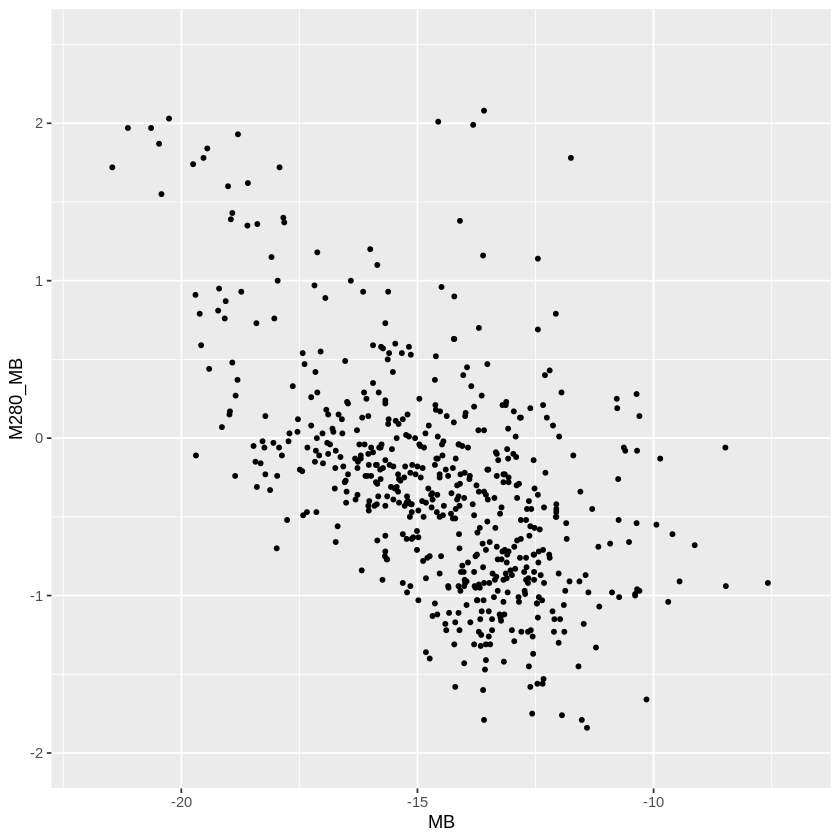

In [6]:
p <- ggplot(COMBO_loz, aes(x=MB, y=M280_MB))+
    geom_point(size=1) +
    xlim(-22,-7) + ylim(-2,2.5) +
    theme(aspect.ratio = 1)

p


Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select




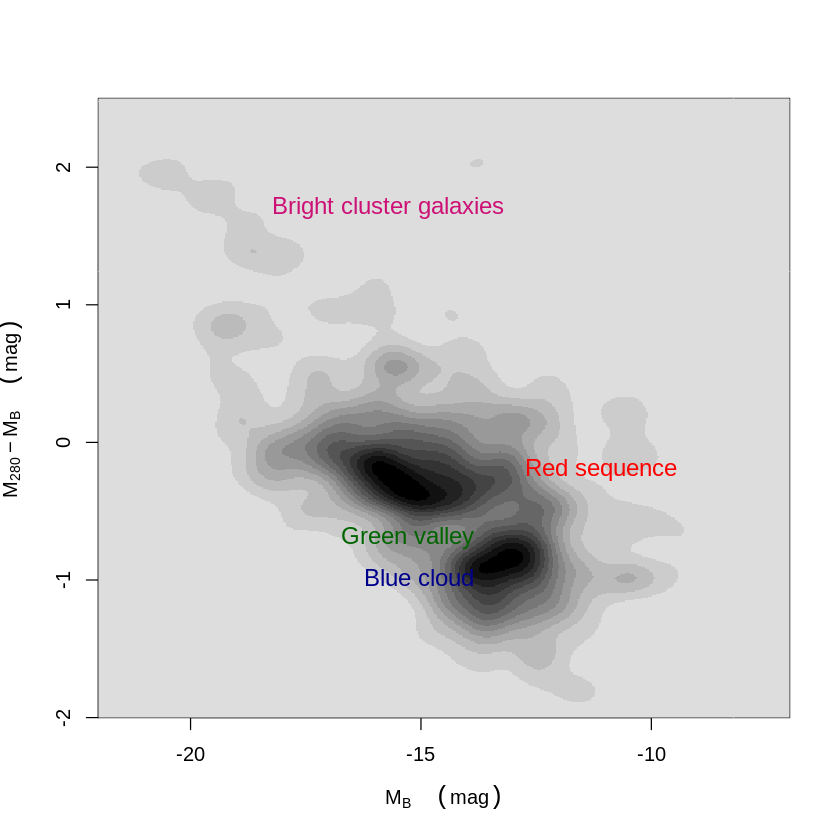

In [7]:
# Two-dimensional kernel-density estimator
# plot below from the author (subect matter expert who provided the labels)
library(MASS)
COMBO_loz_sm <- kde2d(COMBO_loz[,1], COMBO_loz[,2], h=c(1.6,0.4), 
   lims = c(-22,-7,-2,2.5), n=500)
image(COMBO_loz_sm, col=grey(13:0/15), xlab=expression(M[B]~~(mag)), 
   ylab=expression(M[280] - M[B]~~(mag)), xlim=c(-22,-7), ylim=c(-2,2.5), 
   xaxp=c(-20,-10,2))
text(-16.5, -1, "Blue cloud", col='darkblue', pos=4, cex=1.2)
text(-17,-0.7, 'Green valley', col='darkgreen', pos=4, cex=1.2)
text(-13, -0.2, 'Red sequence', col='red', pos=4, cex=1.2)
text(-18.5, 1.7, 'Bright cluster galaxies', col='deeppink3', pos=4, cex=1.2)
#dev.copy2pdf(file='COMBO17_CMD.pdf')

Warning message:
“Removed 6 rows containing non-finite values (stat_density2d).”


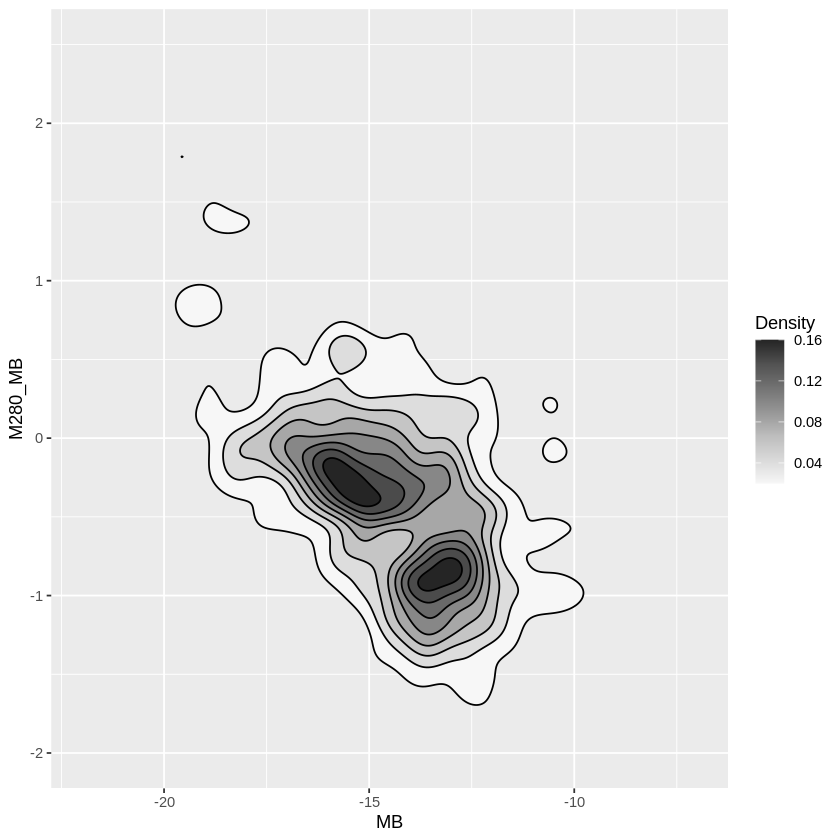

In [8]:
#do the above plot in ggplot
densplot <- COMBO_loz %>%
    ggplot(aes(x=MB, y=M280_MB))+
    stat_density_2d( geom = "density_2d_filled", contour = TRUE, n=500,h=c(1.6,0.4),
                  aes(fill = after_stat(level)), colour = "black") +
  scale_fill_distiller(palette = "Greys", direction = 1)+ 
    xlim(-22,-7) + ylim(-2,2.5)+
    labs(fill="Density")
densplot

In [9]:
#set up some ggplot defaults
options(repr.plot.width=12, repr.plot.height=6)
oldtheme <- theme_set(theme_cowplot(font_size=16)+theme(aspect.ratio=1))

Warning message:
“Removed 6 rows containing missing values (geom_point).”
Warning message:
“Removed 6 rows containing non-finite values (stat_density2d).”


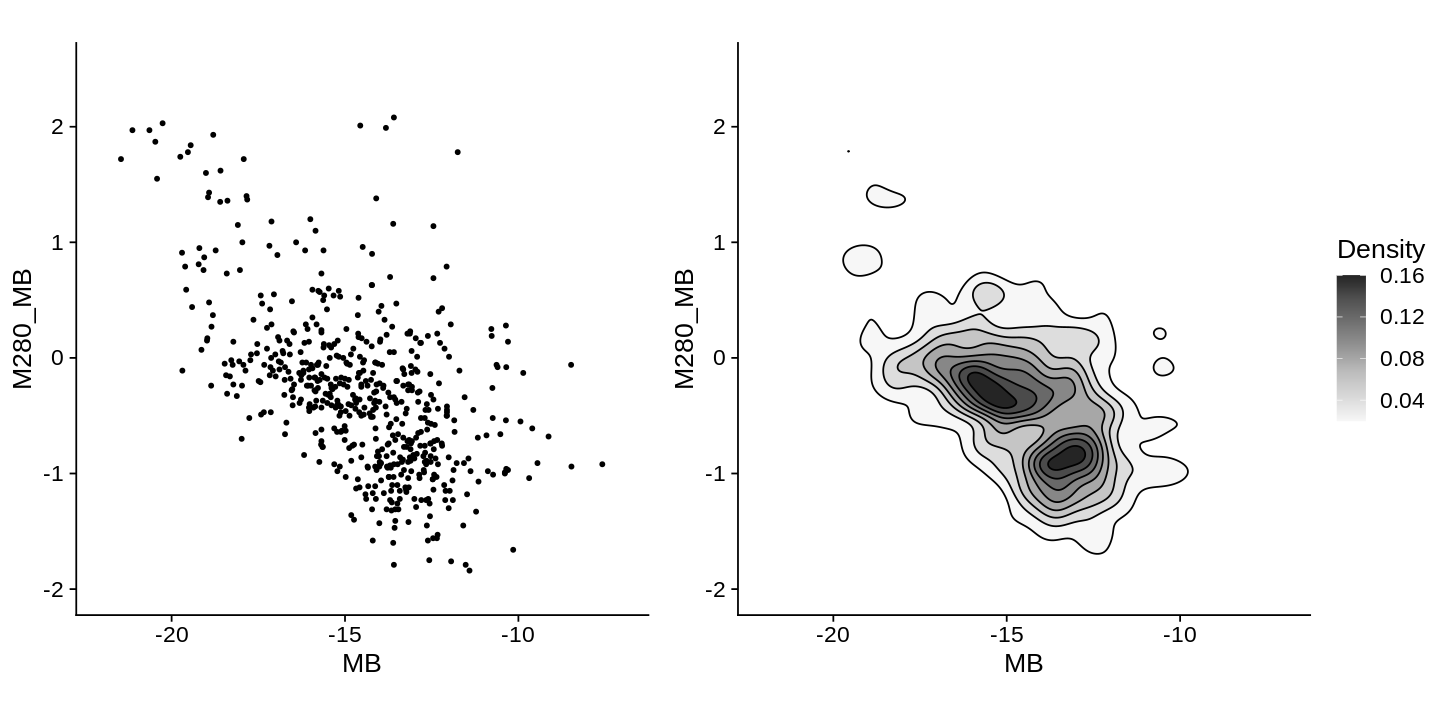

In [10]:
library('grid')

grid.draw(cbind(ggplotGrob(p), ggplotGrob(densplot), size = "last"))

For clustering purposes, we need to standardize the variables, otherwise we'd have problems with scale and dimension.

The `scale` function does this. It subtracts off the mean and divides by the standard deviation.

In [11]:
# verify scale function against hand calculation:
xx_test = (COMBO_loz[,1] - mean(COMBO_loz[,1]))/sd(COMBO_loz[,1])
all.equal(xx_test, c(scale(COMBO_loz[,1])))

[1] TRUE

In [12]:
# Standardize variables and compute a Euclidean distance matrix

Mag_std <- scale(COMBO_loz[,1]) 
Color_std <- scale(COMBO_loz[,2])
COMBO_std <- cbind(Mag_std,Color_std)
COMBO_dist <- dist(COMBO_std)

In [13]:
dist(head(COMBO_std))

          1         2         3         4         5
2 2.0341909                                        
3 1.6348341 1.6483237                              
4 1.5119202 0.5541464 1.2336872                    
5 0.8320945 2.1747909 2.3363773 1.7802259          
6 0.2035099 2.0987168 1.5234384 1.5592798 1.0306768

In [14]:
COMBO_std[c(1,2),]

1.5101825,-1.0204477
0.2415539,0.5696825


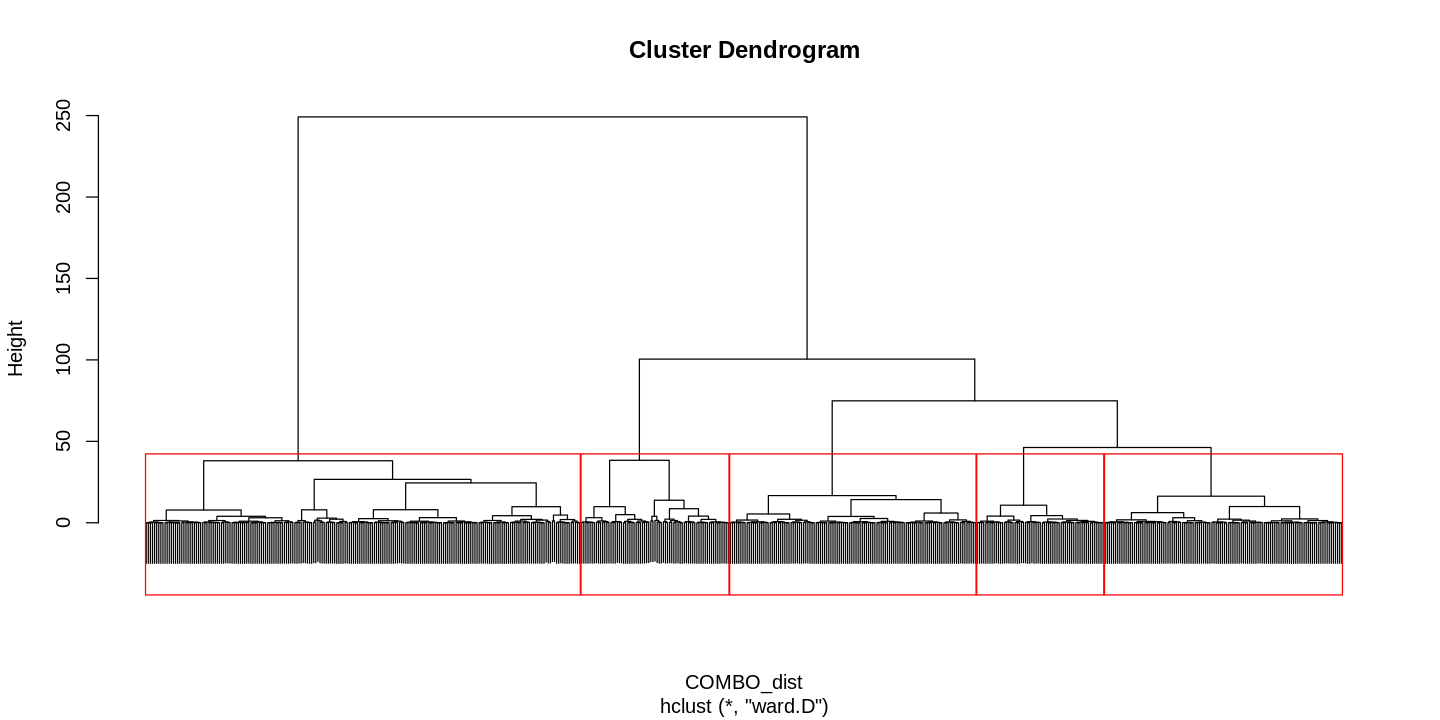

In [15]:
# Hierarchical clustering

COMBO_hc <- hclust(COMBO_dist, method='ward.D')
plot(COMBO_hc, label=F)

# Cutting the tree at k=5 clusters

COMBO_hc5a <- rect.hclust(COMBO_hc, k=5, border='red') 
COMBO_hc5b <- cutree(COMBO_hc, k=5) 

Warning message:
“Removed 6 rows containing non-finite values (stat_density2d).”
Warning message:
“Removed 6 rows containing missing values (geom_point).”


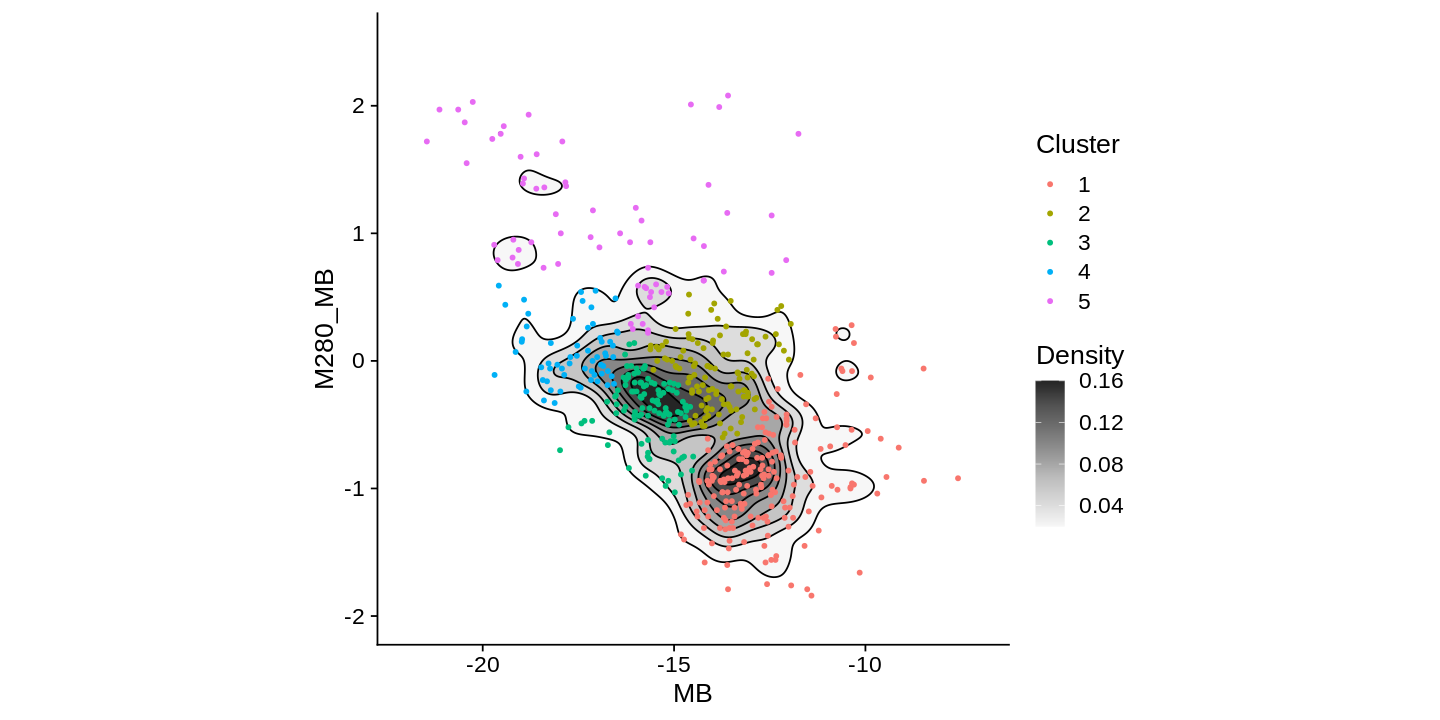

In [16]:
densplot +
    geom_point( size=1, aes(color=as.factor(COMBO_hc5b))) +
    labs(color='Cluster')

In [17]:
# abbr. list of hclust methods, see help(hclust)
hcmeth = c('ward.D','median', 'centroid')

#for complete set of available cluster methods, uncomment the following:
#hcmeth = c("ward.D", "ward.D2", "single", "complete", "average", "mcquitty", "median", "centroid")

hclist = list()
for (m in hcmeth) {
    hclist[[m]]  <- hclust(COMBO_dist, method=m)
}

In [18]:
for (m in hcmeth){
    members <- cutree(hclist[[m]], k=5)
    COMBO_loz[paste(m,'members', sep='.')]=as.factor(members)
}
head(COMBO_loz)

,MB,M280_MB,ward.D.members,median.members,centroid.members
,<dbl>,<dbl>,<fct>,<fct>,<fct>
1,-11.15,-1.07,1,1,1
2,-13.99,0.14,2,2,1
3,-10.30,0.14,1,1,1
4,-12.97,-0.10,2,1,1
5,-12.64,-1.45,1,1,1
6,-10.73,-1.01,1,1,1


In [19]:
# make long skinny dataframe for ggplot
cols = paste(hcmeth,'members',sep='.')
member_df <- COMBO_loz %>% gather(key="method", value="Member.id", all_of(cols))
head(member_df); tail(member_df)

,MB,M280_MB,method,Member.id
,<dbl>,<dbl>,<chr>,<chr>
1,-11.15,-1.07,ward.D.members,1
2,-13.99,0.14,ward.D.members,2
3,-10.30,0.14,ward.D.members,1
4,-12.97,-0.10,ward.D.members,2
5,-12.64,-1.45,ward.D.members,1
6,-10.73,-1.01,ward.D.members,1


,MB,M280_MB,method,Member.id
,<dbl>,<dbl>,<chr>,<chr>
1711,-12.52,-0.57,centroid.members,1
1712,-17.73,-0.02,centroid.members,1
1713,-14.02,-0.85,centroid.members,1
1714,-13.00,-0.87,centroid.members,1
1715,-10.36,0.28,centroid.members,1
1716,-15.22,-0.98,centroid.members,1


In [20]:
install.packages("ggdendro")
library(ggdendro)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



$median



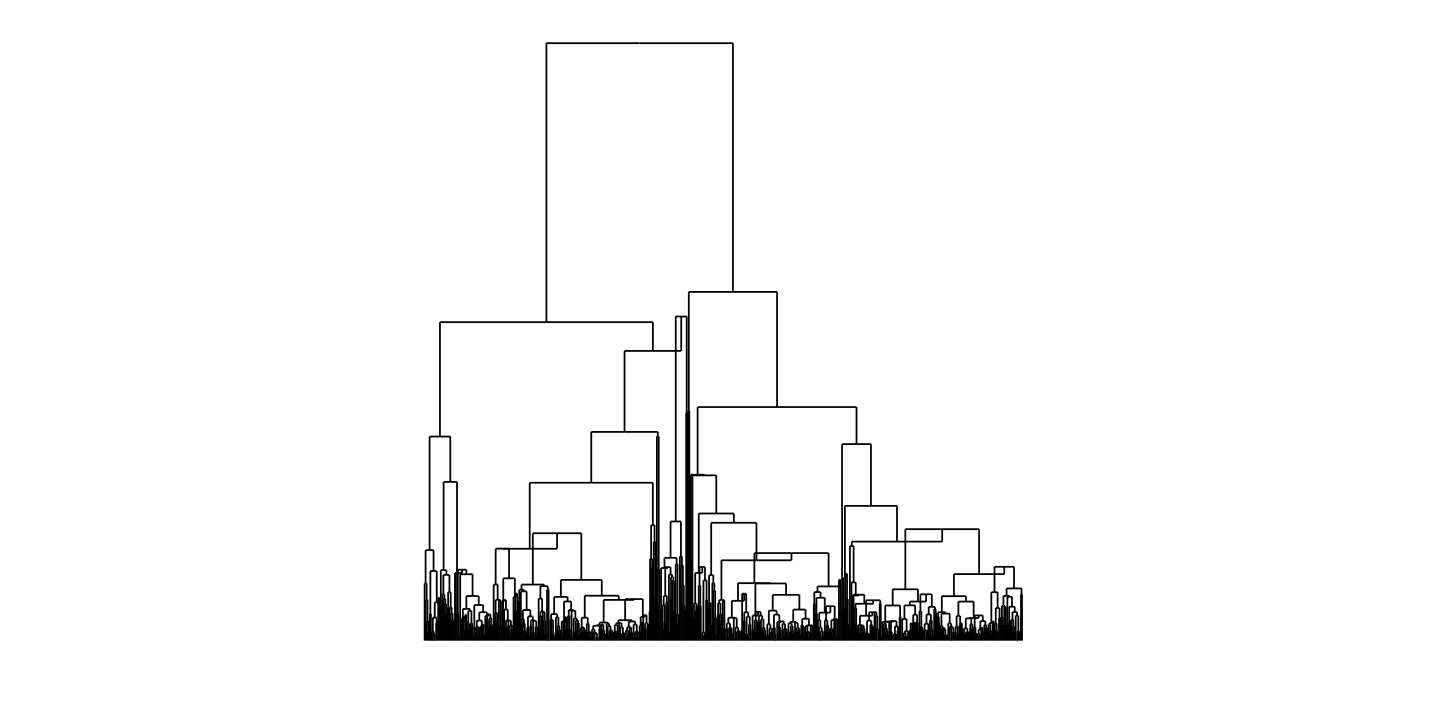

In [21]:
options(repr.plot.width=12, repr.plot.height=6)
#make dendrograms for each of the hclust methods
dendros <- list()
for (m in hcmeth){
    dendros[[m]] <- ggdendrogram( hclist[[m]] ) +ggtitle(m) + theme_dendro()+
    labs(title= NULL)

}

#pick one of the methods and print it
print(dendros['median'])

Warning message:
“Removed 18 rows containing non-finite values (stat_density2d).”
Warning message:
“Removed 18 rows containing missing values (geom_point).”


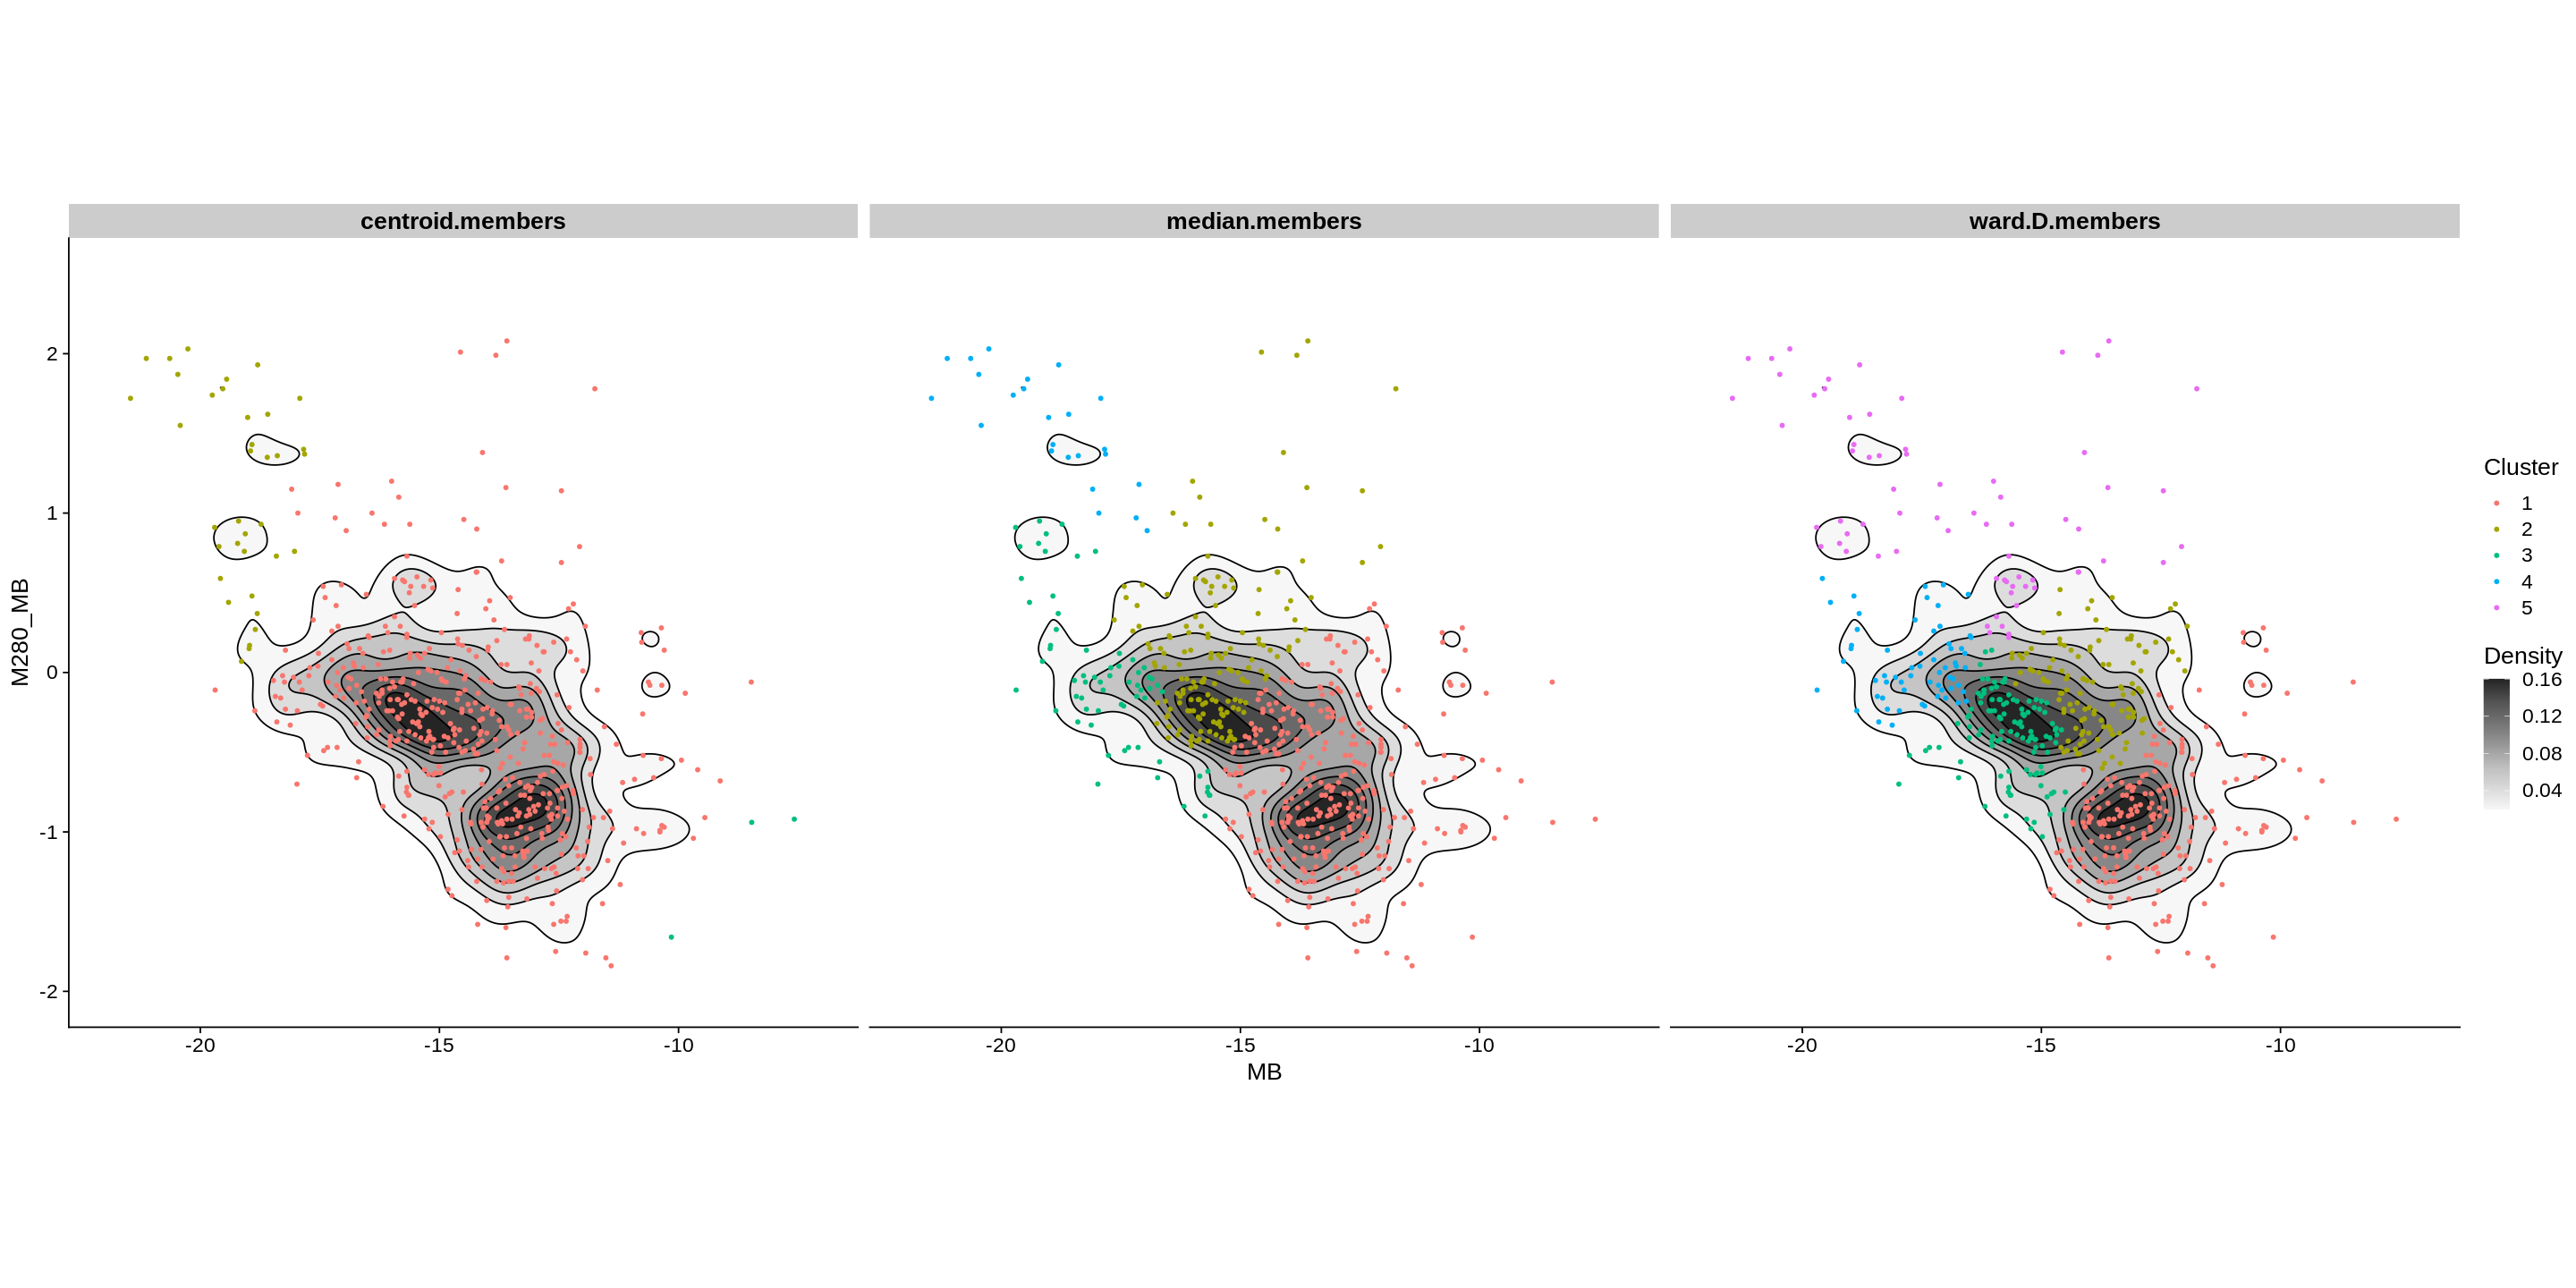

In [22]:
#plot the clustering results side-by-side
options(repr.plot.width=24, repr.plot.height=12)
densplot +
    geom_point(data=member_df,aes(x=MB, y=M280_MB, color=Member.id), size=1)+
    labs(color='Cluster') +
    facet_wrap(~ method, nrow=2, ncol=4) +
    theme(strip.text.x = element_text(size=16, face="bold"))

Plot the dendrogram along side of density/membership plot to see how the dendrogram results in membership assignment.

In [23]:
#Need a function to plot the membership on top of the density plot
getplot <- function(meth, data=member_df, dp=densplot){
    dp +
    geom_point(data=filter(data, method==paste(meth,'members',sep='.')),aes(x=MB, y=M280_MB, color=Member.id), size=1)+
        labs(color='Cluster') +
        theme(strip.text.x = element_text(size=16, face="bold"))
    
}

Warning message:
“Removed 6 rows containing non-finite values (stat_density2d).”
Warning message:
“Removed 6 rows containing missing values (geom_point).”
Warning message:
“Removed 6 rows containing non-finite values (stat_density2d).”
Warning message:
“Removed 6 rows containing missing values (geom_point).”
Warning message:
“Removed 6 rows containing non-finite values (stat_density2d).”
Warning message:
“Removed 6 rows containing missing values (geom_point).”


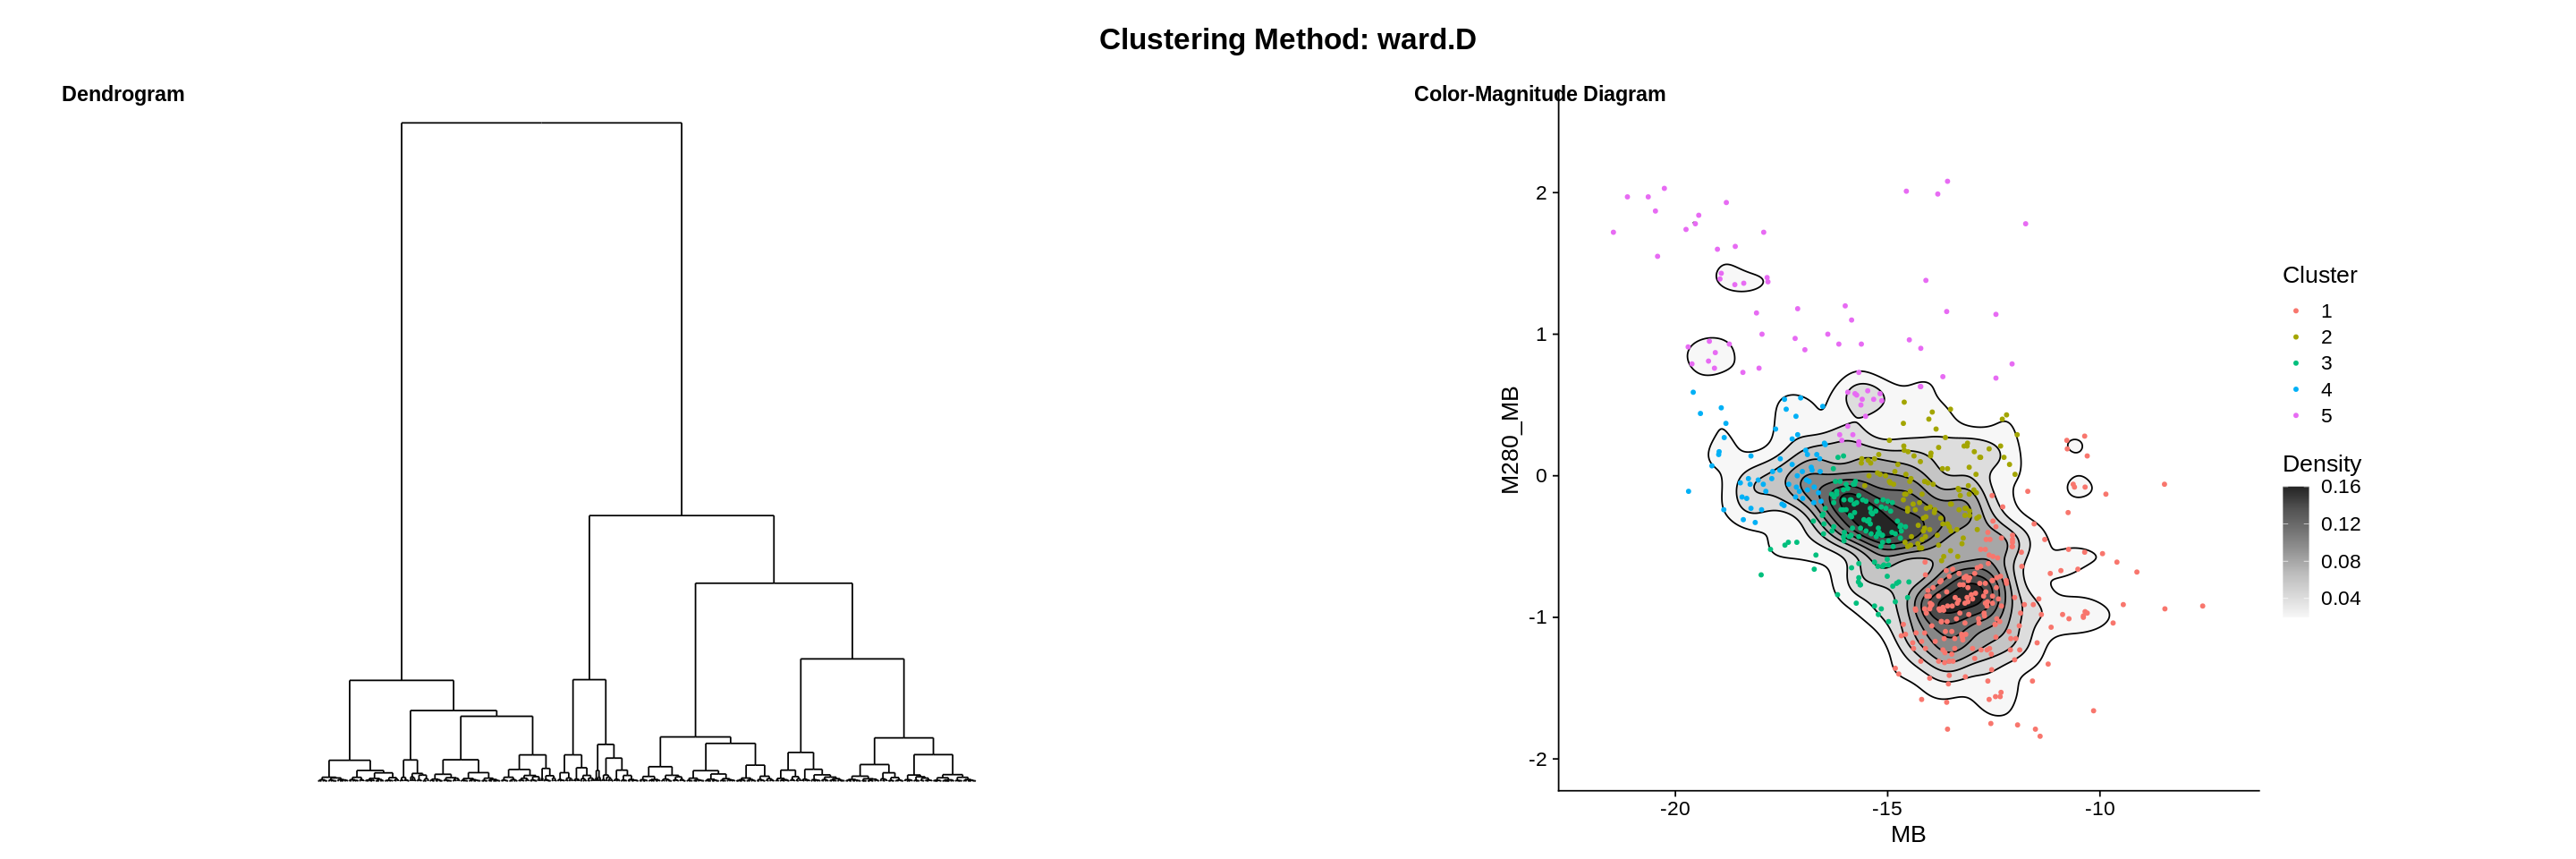

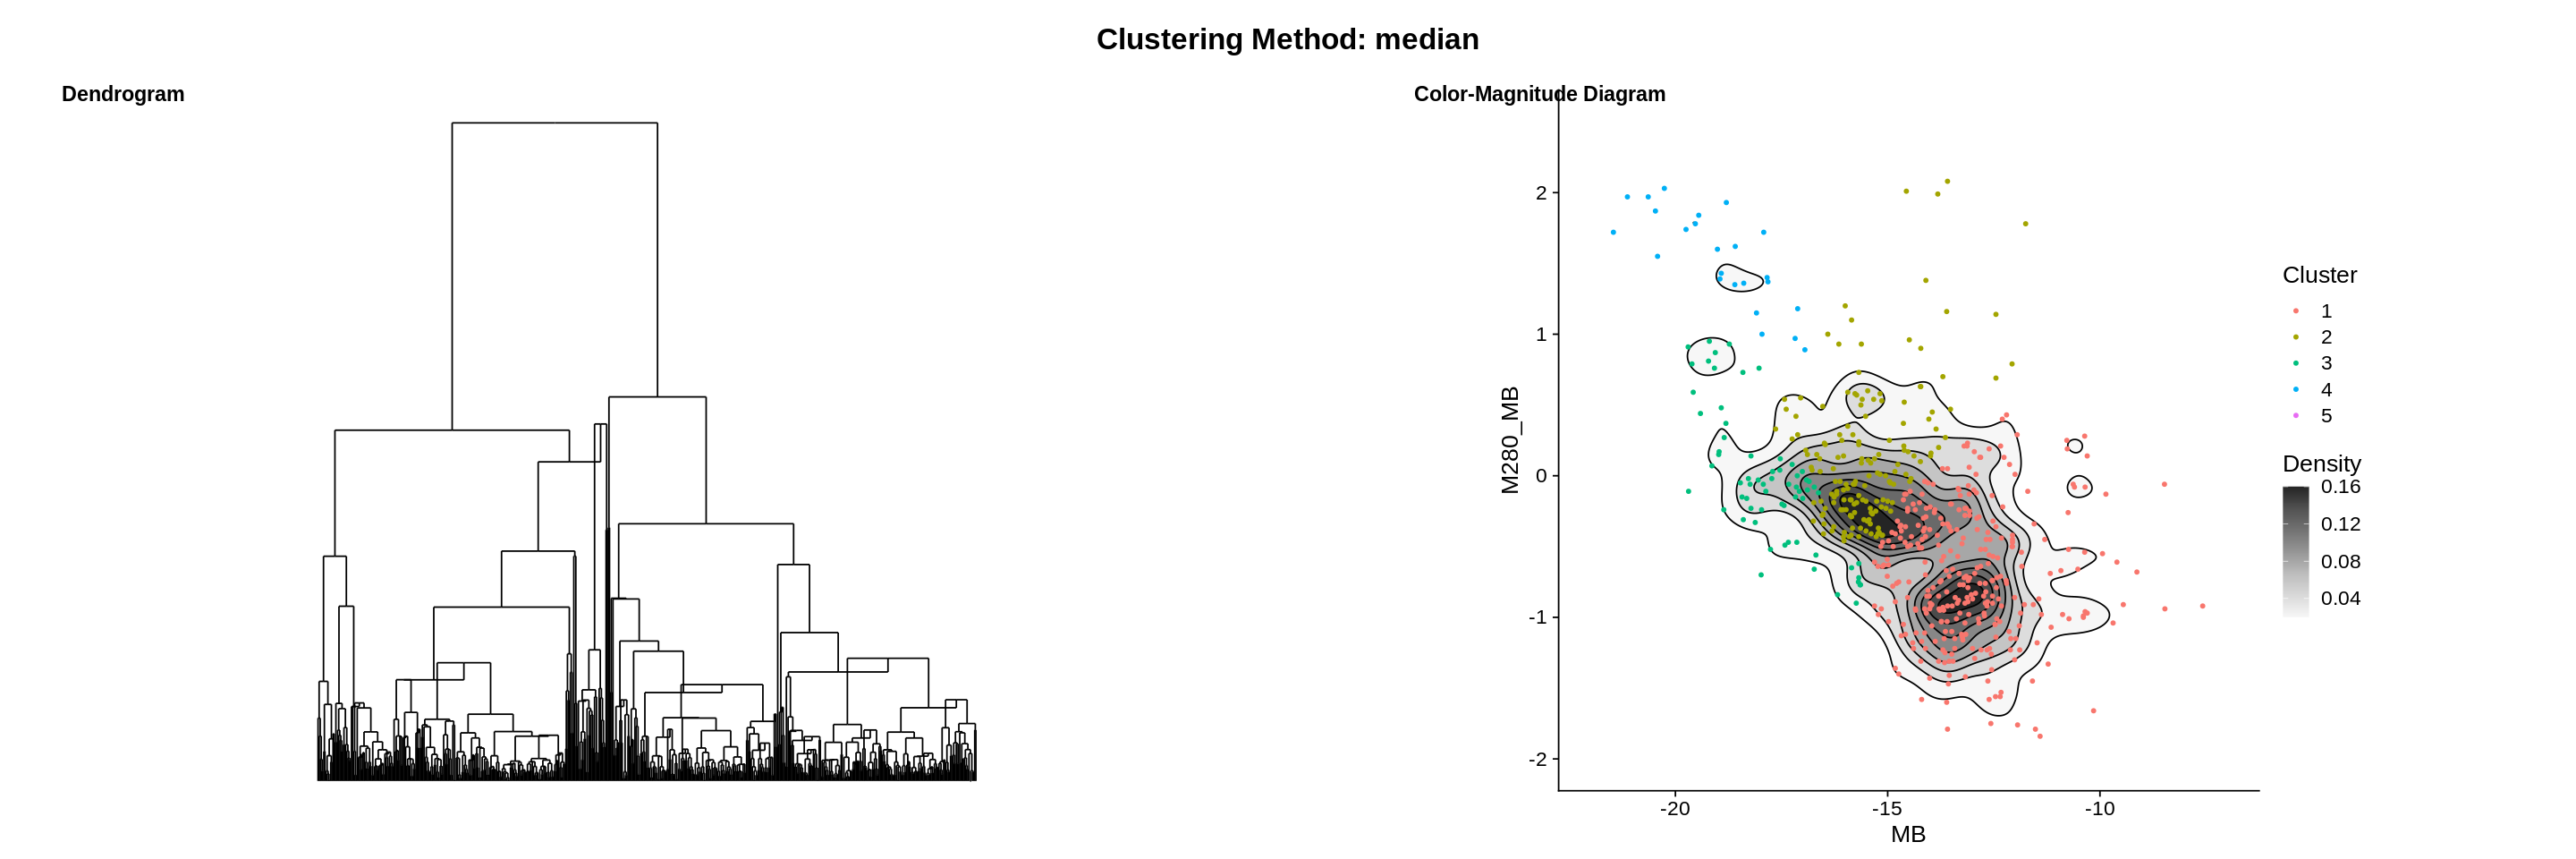

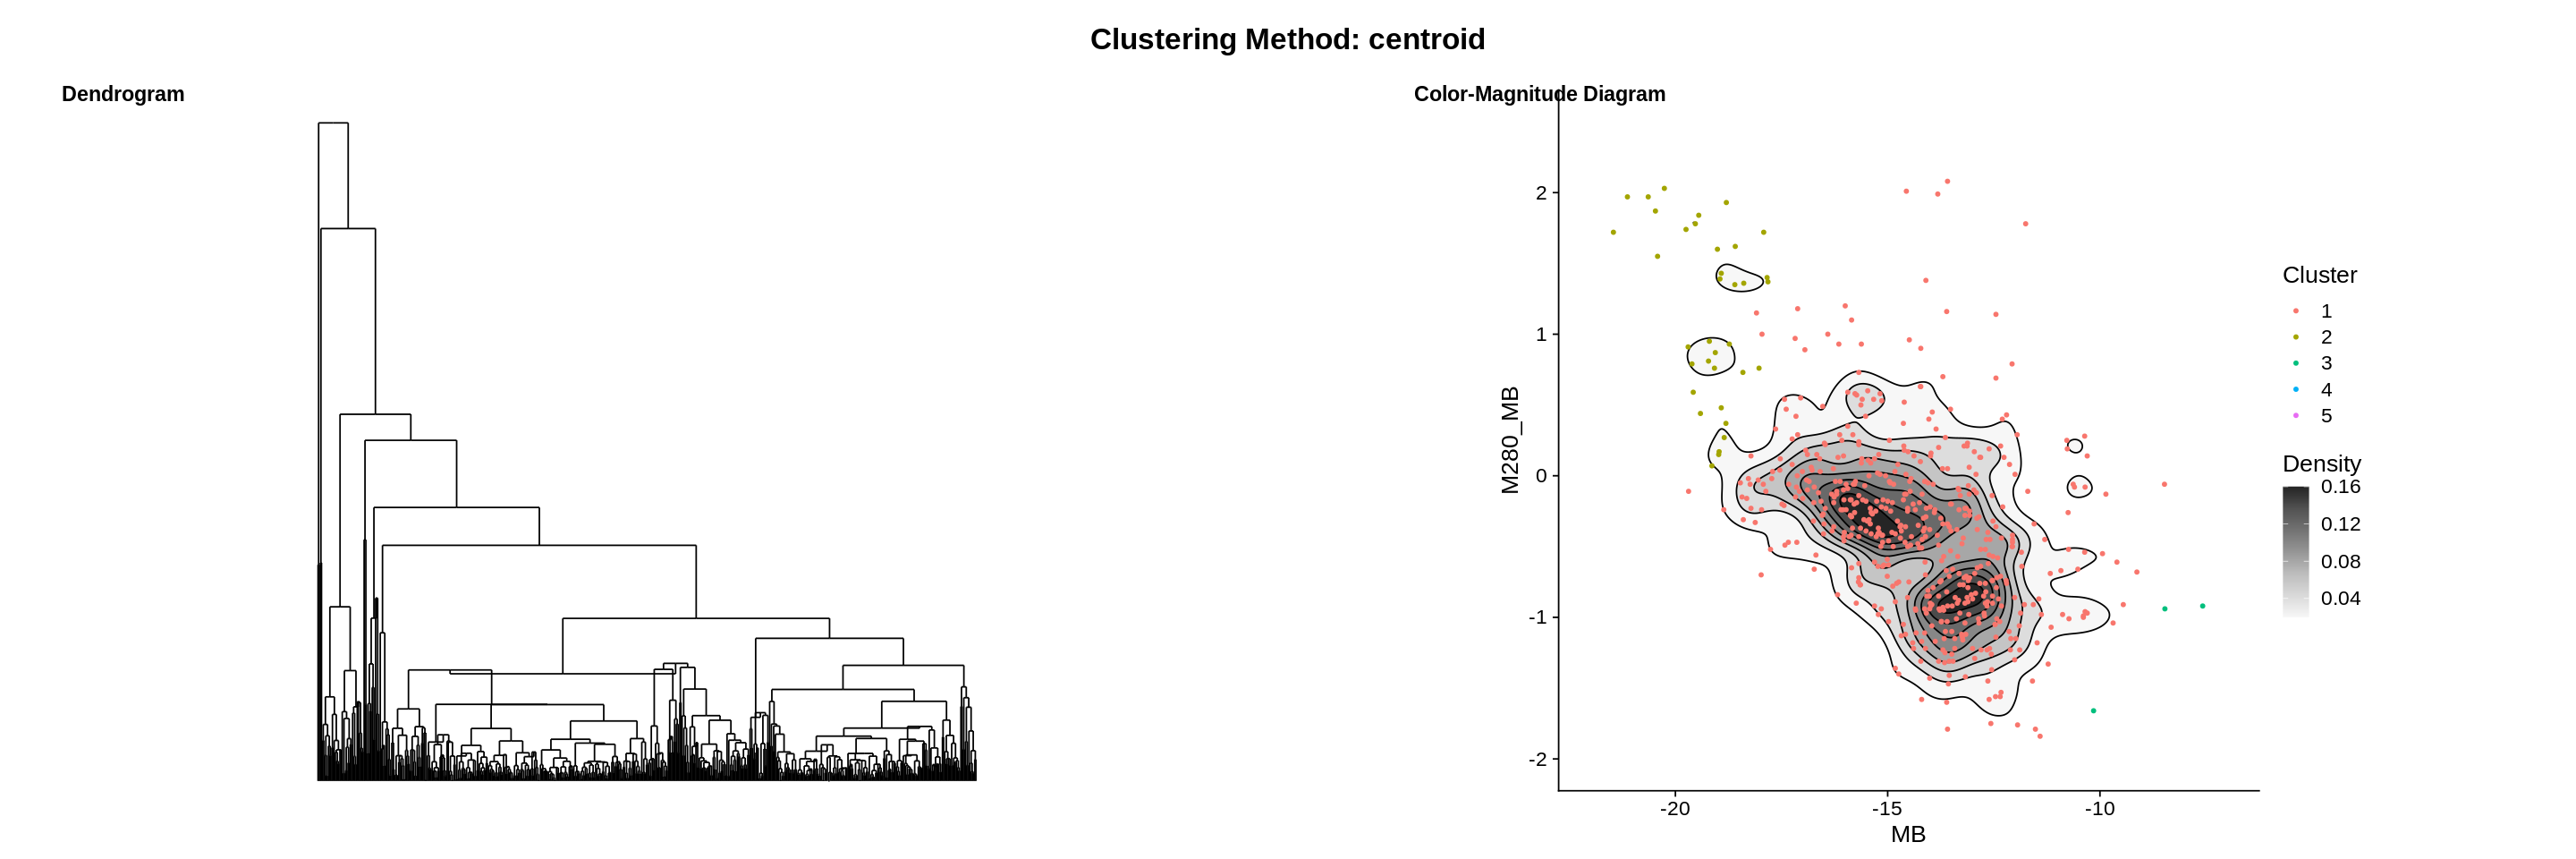

In [24]:
options(repr.plot.width=24, repr.plot.height=8)

#use cowplot to produce the side-by-side plot
for (m in hcmeth){
    plts = cowplot::plot_grid(dendros[[m]],getplot(m), labels=c('Dendrogram','Color-Magnitude Diagram'))
    plt_title = ggdraw()+cowplot::draw_label(paste('Clustering Method:',m), fontface="bold", size=20)
          
    print(
      cowplot::plot_grid(plt_title, plts, nrow=2, ncol=1,rel_heights = c(1,10))
     )
    }